# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит вайл, не праильного офрмата или неверное окличество строк, метрика будет = 0.

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils.testing import ignore_warnings

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [4]:
pd.set_option('max_columns', 40)

Функция для вывода данных моделей

In [5]:
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_

### Подгружаем данные

In [6]:
# !wget https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv
# !wget https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv
# !wget https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-desc.csv

In [7]:
train_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv', sep=';')
test_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv', sep=';')
desc_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-desc.csv', sep=';')

Описание данных

In [8]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


Семплы и размеры выборок

In [9]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0


In [10]:
train_df.shape

(32395, 37)

Посмотрим на данные

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

In [12]:
pd.unique(train_df[['default_12m']].values.ravel('K'))

array([0, 1])

Есть пропуски и несбалансированность классов

Text(0.5, 1.0, 'target')

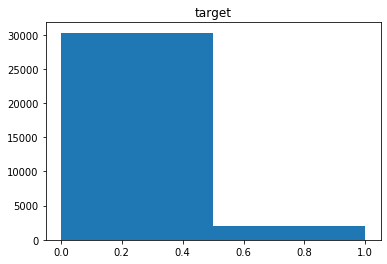

In [13]:
fig, axs = plt.subplots()
axs.hist(train_df['default_12m'], bins=2)
axs.set_title('target')

In [14]:
train_df.default_12m.value_counts()

0    30304
1     2091
Name: default_12m, dtype: int64

Корреляции признакой с целевой переменной нет

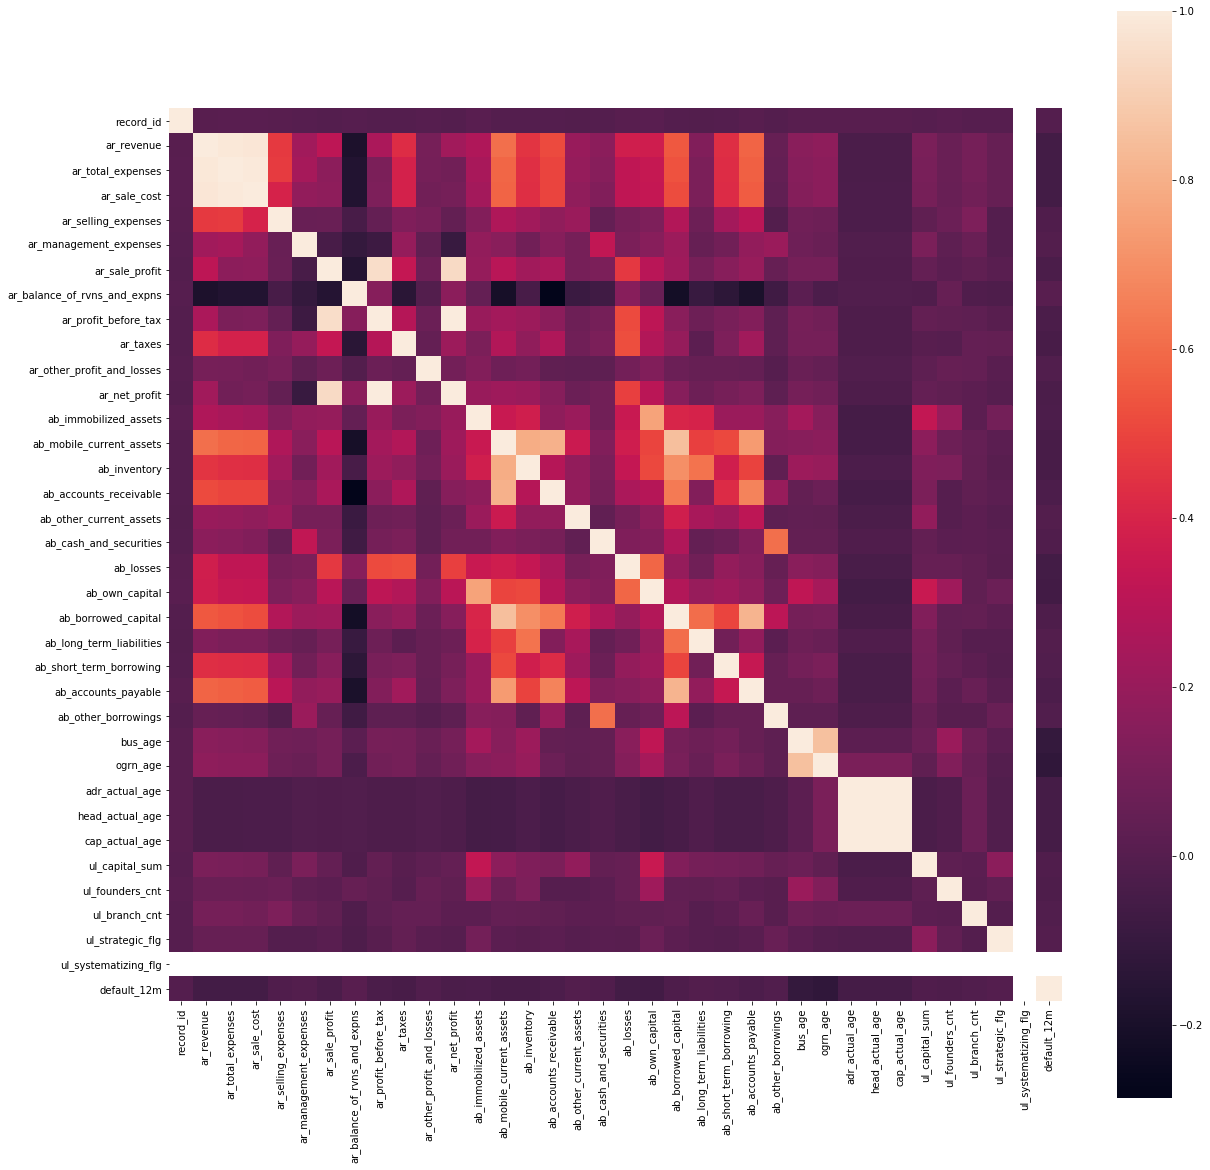

In [15]:
plt.subplots(figsize=(20,20))
sns.heatmap(train_df.corr(), square=True)
plt.show()

Начнем обработку данных, применим One hot для количества сотрудников. Названия столбцов надо поменять для использования бустингов

In [18]:
train = pd.get_dummies(train_df, columns=['ul_staff_range'], drop_first=False)
train.rename(columns={'ul_staff_range_(100-500]': 'ul_staff_range_100-500',
                      'ul_staff_range_> 500': 'ul_staff_range_500',
                      'ul_staff_range_[1-100]': 'ul_staff_range_1-100'},
             inplace=True)

In [19]:
train.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m,ul_staff_range_100-500,ul_staff_range_500,ul_staff_range_1-100
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,50000.0,2,0,0,0,0,0,0,1
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,10000.0,5,0,0,0,0,0,0,1
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,10000.0,2,0,0,0,0,0,0,1
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,300000.0,1,0,0,0,0,0,0,1
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,10000.0,2,0,0,0,0,0,0,1


Заменим пропущенные элементы на средние значения и на нули. Выборка с нулями показала плохой результат, поэтому ее нет в данном ноутбуке

In [20]:
reg_train = train_df.fillna(train_df.median(axis=0), axis=0)
reg_train = reg_train.drop(['default_12m', 'record_id'], axis=1)

In [21]:
reg_train = pd.get_dummies(reg_train, columns=['ul_staff_range'], drop_first=False)
reg_train.rename(columns={
    'ul_staff_range_(100-500]': 'ul_staff_range_100-500',
    'ul_staff_range_> 500': 'ul_staff_range_500',
    'ul_staff_range_[1-100]': 'ul_staff_range_1-100'
},inplace=True)

In [22]:
reg_train.head()

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range_100-500,ul_staff_range_500,ul_staff_range_1-100
0,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,50000.0,2,0,0,0,0,0,1
1,32335000.0,29703500.0,28408000.0,0.0,0.0,1231500.0,-126000.0,850000.0,41000.0,0.0,704000.0,0.0,11094500.0,4714500.0,3028500.0,0.0,264000.0,673000.0,3528000.0,7231000.0,0.0,361000.0,3678000.0,0.0,256,135,12,12,12,10000.0,5,0,0,0,0,0,1
2,32335000.0,29703500.0,28408000.0,0.0,0.0,1231500.0,-126000.0,850000.0,41000.0,0.0,704000.0,0.0,11094500.0,4714500.0,3028500.0,0.0,264000.0,673000.0,3528000.0,7231000.0,0.0,361000.0,3678000.0,0.0,33,33,28,28,28,10000.0,2,0,0,0,0,0,1
3,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,300000.0,1,0,0,0,0,0,1
4,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,10000.0,2,0,0,0,0,0,1


Зафиксируем новые фичи

In [23]:
features_reg = reg_train.columns.tolist()
features_reg

['ar_revenue',
 'ar_total_expenses',
 'ar_sale_cost',
 'ar_selling_expenses',
 'ar_management_expenses',
 'ar_sale_profit',
 'ar_balance_of_rvns_and_expns',
 'ar_profit_before_tax',
 'ar_taxes',
 'ar_other_profit_and_losses',
 'ar_net_profit',
 'ab_immobilized_assets',
 'ab_mobile_current_assets',
 'ab_inventory',
 'ab_accounts_receivable',
 'ab_other_current_assets',
 'ab_cash_and_securities',
 'ab_losses',
 'ab_own_capital',
 'ab_borrowed_capital',
 'ab_long_term_liabilities',
 'ab_short_term_borrowing',
 'ab_accounts_payable',
 'ab_other_borrowings',
 'bus_age',
 'ogrn_age',
 'adr_actual_age',
 'head_actual_age',
 'cap_actual_age',
 'ul_capital_sum',
 'ul_founders_cnt',
 'ul_branch_cnt',
 'ul_strategic_flg',
 'ul_systematizing_flg',
 'ul_staff_range_100-500',
 'ul_staff_range_500',
 'ul_staff_range_1-100']

Обработаем тестовыю выборку

Интересно, какого результата удатся достичь с минимальной обработкой данных - без очистки выбросов, дублей и без выравнивания классов SMOTE. Буду использовать регрессию, случайные леса, XGBoost и DecisionTree. После обучения на этих фичах я добавлю рентабельность, рентабельность капитала и быструю ликвидность. Понимаю, что можно добавить больше фичей по финансам, но для этого лучше разделить данные на полные и на данные с пропусками и обучать отдельно, а времени мало. 

In [24]:
test_df_new = test_df

In [25]:
test_df_new = test_df_new.fillna(test_df_new.median(axis=0), axis=0)

In [26]:
test_df_new_reg = test_df_new
test_df_new_reg = pd.get_dummies(test_df_new_reg, columns=['ul_staff_range'], drop_first=False)
test_df_new_reg.rename(columns={'ul_staff_range_(100-500]': 'ul_staff_range_100-500', \
                      'ul_staff_range_> 500': 'ul_staff_range_500', \
                      'ul_staff_range_[1-100]': 'ul_staff_range_1-100'}, \
             inplace=True)

Количество разных типов фичей

In [27]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

Уровень дефолт-рейта в выборке = 6,7219%

In [28]:
train_df['default_12m'].values.mean()

0.06454699799351751

In [29]:
train_df.record_id.nunique()

32395

32395 уникальных наблюдений

### Строим бэйзлайн модель c 3-ми фичами

In [30]:
features = ['bus_age','ul_capital_sum', 'ul_founders_cnt']
features

['bus_age', 'ul_capital_sum', 'ul_founders_cnt']

In [31]:
features_df = train_df.loc[:,features]
features_df['default_12m'] = train_df['default_12m']

In [32]:
features_df.head()

,bus_age,ul_capital_sum,ul_founders_cnt,default_12m
0,198,50000.0,2,0
1,256,10000.0,5,0
2,33,10000.0,2,0
3,185,300000.0,1,0
4,220,10000.0,2,0


### Построим карту коллеряций

In [33]:
features_df.corr()

,bus_age,ul_capital_sum,ul_founders_cnt,default_12m
bus_age,1.000000,0.066929,0.209451,-0.109389
ul_capital_sum,0.066929,1.000000,0.029165,-0.019452
ul_founders_cnt,0.209451,0.029165,1.000000,-0.023244
default_12m,-0.109389,-0.019452,-0.023244,1.000000


### Валидация результата

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features_df.drop('default_12m',axis=1),
                                                    features_df['default_12m'],
                                                    random_state=42, shuffle=True)

logit = LogisticRegression(C=1,solver='lbfgs',max_iter=1000)
cv_baseline = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6483643068016243

ROC/AUC бэйзлайн модели - 64,83%

### Построение модели на всех данных

In [35]:
logit.fit(features_df.drop('default_12m',axis=1), features_df['default_12m'])

LogisticRegression(C=1, max_iter=1000)

In [36]:
features_df.head()

,bus_age,ul_capital_sum,ul_founders_cnt,default_12m
0,198,50000.0,2,0
1,256,10000.0,5,0
2,33,10000.0,2,0
3,185,300000.0,1,0
4,220,10000.0,2,0


In [37]:
new_train_d = train_df.fillna(train_df.median(axis=0), axis=0)
new_train_d = new_train_d.drop(['default_12m', 'record_id', 'ul_staff_range'], axis=1)

In [38]:
logit.fit(new_train_d, train_df['default_12m'])

LogisticRegression(C=1, max_iter=1000)

In [39]:
features = new_train_d.columns.tolist()
features

['ar_revenue',
 'ar_total_expenses',
 'ar_sale_cost',
 'ar_selling_expenses',
 'ar_management_expenses',
 'ar_sale_profit',
 'ar_balance_of_rvns_and_expns',
 'ar_profit_before_tax',
 'ar_taxes',
 'ar_other_profit_and_losses',
 'ar_net_profit',
 'ab_immobilized_assets',
 'ab_mobile_current_assets',
 'ab_inventory',
 'ab_accounts_receivable',
 'ab_other_current_assets',
 'ab_cash_and_securities',
 'ab_losses',
 'ab_own_capital',
 'ab_borrowed_capital',
 'ab_long_term_liabilities',
 'ab_short_term_borrowing',
 'ab_accounts_payable',
 'ab_other_borrowings',
 'bus_age',
 'ogrn_age',
 'adr_actual_age',
 'head_actual_age',
 'cap_actual_age',
 'ul_capital_sum',
 'ul_founders_cnt',
 'ul_branch_cnt',
 'ul_strategic_flg',
 'ul_systematizing_flg']

### Формирование файла с ответом

In [40]:
answ_df = test_df[['record_id']]

In [41]:
answ_df['id'] = answ_df['record_id']

In [42]:

answ_df.drop('record_id',axis=1, inplace=True)

In [43]:
cutoff = y_train.mean()

In [44]:
cutoff

0.06548403029305236

In [43]:
# answ_df['predict'] = (logit.predict_proba(test_df.loc[:,features])[:,1]>cutoff).astype(int)

In [44]:
# answ_df['predict'] = (logit.predict_proba(test_df_new[features])[:,1]>cutoff).astype(int)

In [44]:
# answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Для загрузки своего рузультата на https://dsbattle.com/hackathons/juniords/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)

In [64]:
# from google.colab import files
# files.download('PD-submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Обучение моделей

In [61]:
lr = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': [{0:1, 1:2}], 'intercept_scaling':[0.001, 0.01, 0.1, 1],
              'max_iter':[10, 100, 150], 'tol': [0.00001, 0.0001, 0.001]}
clf_lr = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, verbose=5)

clf_lr.fit(reg_train, train_df['default_12m'])

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:  2.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [{0: 1, 1: 2}],
                         'intercept_scaling': [0.001, 0.01, 0.1, 1],
                         'max_iter': [10, 100, 150],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=Tru

In [59]:
get_best_score(clf_lr)

0.875258527550548
{'C': 0.001, 'class_weight': {0: 1, 1: 15}, 'intercept_scaling': 0.001, 'max_iter': 10, 'tol': 1e-05}
LogisticRegression(C=0.001, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=0.001, l1_ratio=None,
                   max_iter=10, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)


0.875258527550548

In [60]:
answ_df['predict'] = (clf_lr.predict_proba(test_df_new_reg.loc[:,features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')
# from google.colab import files
# files.download('PD-submit.csv')

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 7, 8, 10], 'max_features': [6,8,10,20,50],  
              'min_samples_split': [1, 2, 4, 5, 6]} # , 11, 12, 14, 15]}

rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=1, n_jobs=-1)
rf_grid.fit(new_train_d, train_df['default_12m'])

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:  3.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [38]:
get_best_score(rf_grid)

0.9359469053866338
{'max_depth': 10, 'max_features': 20, 'min_samples_split': 2}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


0.9359469053866338

In [166]:
answ_df['predict'] = (rf_grid.predict_proba(test_df_new.loc[:,features])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')
# from google.colab import files
# files.download('PD-submit.csv')

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [60]:
from sklearn.svm import SVC

model = SVC()
param_grid = {'C': [5,10,20], #500,800,1000,1200,1500], 
              'gamma': [0.0000001, 0.000001], #,0.0001,0.00001,0.000001], 
              'kernel': ['linear']}
svc_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, n_jobs=-1)
svc_grid.fit(new_train_d, train_df['default_12m'])
get_best_score(svc_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s remaining:    0.0s


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [71]:
answ_df['predict'] = (svc_grid.predict(test_df_new[features])).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')
# from google.colab import files
# files.download('PD-submit.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {
    'max_depth': [17], 'max_features': [20],  
    'min_samples_split': [4, 6], 'n_estimators': [200, 250], 
    'criterion': ['entropy'], # , 11, 12, 14, 15], 
    'random_state': [42], 'class_weight': [{0:1, 1:2}],
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'bootstrap': [True, False]
}

rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=5, n_jobs=-1, scoring = 'roc_auc')

In [68]:
rf_grid.fit(reg_train, train_df['default_12m'])

Fitting 5 folds for each of 2004 candidates, totalling 10020 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.4min


KeyboardInterrupt: 

In [ ]:
get_best_score(rf_grid)

In [120]:
features_reg = reg_train.columns.tolist()
features_reg

['ar_revenue',
 'ar_total_expenses',
 'ar_sale_cost',
 'ar_selling_expenses',
 'ar_management_expenses',
 'ar_sale_profit',
 'ar_balance_of_rvns_and_expns',
 'ar_profit_before_tax',
 'ar_taxes',
 'ar_other_profit_and_losses',
 'ar_net_profit',
 'ab_immobilized_assets',
 'ab_mobile_current_assets',
 'ab_inventory',
 'ab_accounts_receivable',
 'ab_other_current_assets',
 'ab_cash_and_securities',
 'ab_losses',
 'ab_own_capital',
 'ab_borrowed_capital',
 'ab_long_term_liabilities',
 'ab_short_term_borrowing',
 'ab_accounts_payable',
 'ab_other_borrowings',
 'bus_age',
 'ogrn_age',
 'adr_actual_age',
 'head_actual_age',
 'cap_actual_age',
 'ul_capital_sum',
 'ul_founders_cnt',
 'ul_branch_cnt',
 'ul_strategic_flg',
 'ul_systematizing_flg',
 'ul_staff_range_100-500',
 'ul_staff_range_500',
 'ul_staff_range_1-100']

In [ ]:
answ_df['predict'] = (rf_grid.predict_proba(test_df_new_reg[features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Лучший показатель accuracy по результатам сабмита 60%

Попробуем Random Search

In [73]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': np.linspace(10, 300).astype(int),
    'max_depth': [None] + list(np.linspace(3, 25).astype(int)),
    'max_features': [5, 10, 15, 20, 25, 30],
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [3, 5, 10],
    'bootstrap': [True, False],
    'class_weight': [{0:1, 1:1}],
    'criterion': ['entropy', 'gini']
}

estimator = RandomForestClassifier(random_state = 42)

rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=42)

In [74]:
rs.fit(reg_train, train_df['default_12m'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   17.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:   25.0s remaining:   32.7s
[Parallel(n_jobs=-1)]: Done  20 out of  30 | elapsed:   26.8s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   33.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [75]:
get_best_score(rs)

0.7074092104840167
{'n_estimators': 234, 'min_samples_split': 3, 'max_leaf_nodes': 31, 'max_features': 25, 'max_depth': 23, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 1}, 'bootstrap': True}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 1},
                       criterion='entropy', max_depth=23, max_features=25,
                       max_leaf_nodes=31, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=234,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


0.7074092104840167

In [76]:
answ_df['predict'] = (rs.predict_proba(test_df_new_reg[features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit_rs.csv',index=False, sep=';')

Пробую изменить веса классов с параметром class_weight, это немного улучшило результат до 61%

In [145]:
lr = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': [{0:1, 1:2}], 'intercept_scaling':[0.001, 0.01, 0.1, 1],
              'max_iter':[10, 100, 150], 'tol': [0.00001, 0.0001, 0.001]}
clf_lr = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, verbose=5)

clf_lr.fit(reg_train, train_df['default_12m'])
get_best_score(clf_lr)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  4.3min


0.9277357616916191
{'C': 0.001, 'class_weight': {0: 1, 1: 2}, 'intercept_scaling': 0.01, 'max_iter': 100, 'tol': 1e-05}
LogisticRegression(C=0.001, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=True, intercept_scaling=0.01, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  5.1min finished


0.9277357616916191

In [146]:
answ_df['predict'] = (clf_lr.predict_proba(test_df_new_reg[features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Применим масштабирование для линейной регрессии, для лесов это не нужно

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(reg_train)
scaled_features = scaler.transform(reg_train)
df_train_null_sc = pd.DataFrame(scaled_features)

scaler.fit(test_df_new_regg)
scaled_features = scaler.transform(test_df_new_regg)
df_test_null_sc = pd.DataFrame(scaled_features)

In [69]:
test_df_new_regg = test_df_new_reg.drop(['record_id'], axis=1)

In [130]:
clf_lr.fit(df_train_null_sc, train_df['default_12m'])
get_best_score(rf_grid)

0.9358851674641148
{'max_depth': 10, 'max_features': 20, 'min_samples_split': 5}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


0.9358851674641148

In [59]:
answ_df['predict'] = (clf_lr.predict_proba(df_test_null_sc)[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

NameError: name 'clf_lr' is not defined

Используем параметр class_weight для метода опорных векторов - результаты стали хуже

In [108]:
from sklearn.svm import SVC

model = SVC()
param_grid = {'C': [1, 5,10,20], #500,800,1000,1200,1500], 
              'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], #,0.0001,0.00001,0.000001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'class_weight': [{0:1, 1:2}], 'random_state': [42]} 
#               'probability': ['True']}
svc_grid = GridSearchCV(model, param_grid, refit=True, verbose=2, n_jobs=-1)
svc_grid.fit(reg_train, train_df['default_12m'])
get_best_score(svc_grid)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   57.1s


KeyboardInterrupt: 

In [83]:
answ_df['predict'] = (svc_grid.predict_proba(test_df_new_reg.loc[:, features_clear])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [152]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

Для несбалансированных классов попробую SGDClassifier

In [58]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier()
param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
              'class_weight': [{1:2}], 'random_state': [42]} 
#               'probability': ['True']}
svc_grid = GridSearchCV(model, param_grid, refit=True, verbose=5, n_jobs=-1)
svc_grid.fit(reg_train, train_df['default_12m'])
get_best_score(svc_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 482, in dump
    return Pickler.dump(self, obj)
  File "/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/opt/anaconda3/lib/python3.7/pickle.py", line 549, in save
    self.save_reduce(obj=obj, *rv)
  File "/opt/anaconda3/lib/python3.7/pickle.py", line 662, in save_reduce
    

In [128]:
answ_df['predict'] = (svc_grid.predict(test_df_new_reg.loc[:, features_reg])).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Знаю, что бустинги для данной задачи не подойдут, но хочу попробовать для своего понимания

In [63]:
from xgboost import XGBClassifier
from sklearn.utils.testing import ignore_warnings
xgb = XGBClassifier()
param_grid = {'max_depth': [10,15,20,30], 'gamma': [0.01,0.1, 1, 2], 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5]}

with ignore_warnings(category=DeprecationWarning):
    xgb_grid = GridSearchCV(xgb, param_grid, refit=True, verbose=2, n_jobs=-1)
    xgb_grid.fit(reg_train, train_df['default_12m'], eval_metric='auc')
    get_best_score(xgb_grid)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 16.1min finished


0.9382929464423523
{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 30}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [65]:
answ_df['predict'] = (xgb_grid.predict_proba(test_df_new_reg[features])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [42]:
# xgb_train = reg_train.rename(columns={'ul_staff_range_(100-500]': 'ul_staff_range_100-500', 'ul_staff_range_> 500': 'ul_staff_range_500', 'ul_staff_range_[1-100]': 'ul_staff_range_1-100'}, inplace=True)

In [84]:
features_xgb = reg_train.columns.tolist()
features_xgb

['ar_revenue',
 'ar_total_expenses',
 'ar_sale_cost',
 'ar_selling_expenses',
 'ar_management_expenses',
 'ar_sale_profit',
 'ar_balance_of_rvns_and_expns',
 'ar_profit_before_tax',
 'ar_taxes',
 'ar_other_profit_and_losses',
 'ar_net_profit',
 'ab_immobilized_assets',
 'ab_mobile_current_assets',
 'ab_inventory',
 'ab_accounts_receivable',
 'ab_other_current_assets',
 'ab_cash_and_securities',
 'ab_losses',
 'ab_own_capital',
 'ab_borrowed_capital',
 'ab_long_term_liabilities',
 'ab_short_term_borrowing',
 'ab_accounts_payable',
 'ab_other_borrowings',
 'bus_age',
 'ogrn_age',
 'adr_actual_age',
 'head_actual_age',
 'cap_actual_age',
 'ul_capital_sum',
 'ul_founders_cnt',
 'ul_branch_cnt',
 'ul_strategic_flg',
 'ul_systematizing_flg',
 'ul_staff_range_100-500',
 'ul_staff_range_500',
 'ul_staff_range_1-100']

In [79]:
params_n = {
    'eta': [1, 0.1, 0.01],
    'max_depth': [20, 30, 40],
#     'subsample': [0.8, 0.1, 1, 0.01],
    'colsample_bytree': [0.1, 1, 0.01],
    'n_estimators': [100, 150, 200],
    
    'gamma': [0.01, 0.1, 1],
#     'lambda': [0, 1],
#     'alpha': [0, 1],
    'min_child_weight': [0, 1],
    'learning_rate': [0.01, 0.1, 1],
    
#     'eval_metric': 'auc',
#      'objective': 'binary:logistic' ,
#     'booster': 'gbtree',
#     'n_jobs': 10,
#     'tree_method': 'approx'
}

In [80]:
from xgboost import XGBClassifier
from sklearn.utils.testing import ignore_warnings

xgb = XGBClassifier()

xgb_grid = GridSearchCV(xgb, params_n, n_jobs=-1, refit=True, verbose=5)
xgb_grid.fit(reg_train, train_df['default_12m'], eval_metric='auc')

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale..., seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.1, 1, 0.01],
                         'eta': [1, 0.1, 0.01], 'gamma': [0.01, 0.1, 1],
                         'learning_rate': [0.01, 0.1

In [81]:
get_best_score(xgb_grid)

0.9382929464423523
{'colsample_bytree': 1, 'eta': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 30, 'min_child_weight': 1, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


0.9382929464423523

In [82]:
xgb_test = test_df_new_reg.rename(columns={'ul_staff_range_(100-500]': 'ul_staff_range_100-500', 'ul_staff_range_> 500': 'ul_staff_range_500', 'ul_staff_range_[1-100]': 'ul_staff_range_1-100'}, inplace=True)


In [85]:
answ_df['predict'] = (xgb_grid.predict_proba(test_df_new_reg[features_xgb])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Решающее дерево, также пробовал настраивать class_weight

In [128]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

param_grid = {'min_samples_split': [2,4,7,10,12, 20, 28, 30, 33],
              'max_depth': [4, 5, 7, 10, 12, 20, 30],
              'max_features':[5, 8, 15, 20, 30],
              'ccp_alpha': [0.01, 0.1],
              'criterion': ['gini', 'entropy'],
              'class_weight': [{0:1, 1:1}],
              'random_state': [42]
             }
dtree_grid = GridSearchCV(dtree, param_grid, refit=True, verbose=1, n_jobs=-1)

In [129]:
dtree_grid.fit(reg_train, train_df['default_12m'])

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 2424 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 3074 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5314 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:  1.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.1],
                         '

In [130]:
get_best_score(dtree_grid)

0.9354530020064825
{'ccp_alpha': 0.01, 'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 4, 'max_features': 5, 'min_samples_split': 2, 'random_state': 42}
DecisionTreeClassifier(ccp_alpha=0.01, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=4, max_features=5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')


0.9354530020064825

In [131]:
answ_df['predict'] = (dtree_grid.predict_proba(test_df_new_reg[features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Пробую CatBoostClassifier

In [75]:
from catboost import CatBoostClassifier
cb_mod = CatBoostClassifier()
param_grid = {
   'bagging_temperature': [1],
   'random_strength': [1, 3],
   'thread_count': [1, 3],
   'iterations': [500, 600],
   'l2_leaf_reg': [3.0, 4.0], 
   'learning_rate': [0.1, 0.3, 0.7],
   'random_seed': [63],
   'od_type': ['Iter'],
   'od_wait': [20],
   'custom_loss': ['AUC', 'Accuracy']
}

best_model = GridSearchCV(cb_mod, param_grid, refit=True, verbose=5, n_jobs=-1)

In [76]:
best_model.fit(reg_train, train_df['default_12m'])

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 29.0min finished


0:	learn: 0.5822670	total: 25.2ms	remaining: 15.1s
1:	learn: 0.4958014	total: 46.6ms	remaining: 13.9s
2:	learn: 0.4310696	total: 67.4ms	remaining: 13.4s
3:	learn: 0.3841816	total: 89.8ms	remaining: 13.4s
4:	learn: 0.3477428	total: 111ms	remaining: 13.2s
5:	learn: 0.3195980	total: 132ms	remaining: 13s
6:	learn: 0.2995416	total: 152ms	remaining: 12.9s
7:	learn: 0.2836339	total: 173ms	remaining: 12.8s
8:	learn: 0.2708581	total: 194ms	remaining: 12.7s
9:	learn: 0.2617360	total: 214ms	remaining: 12.7s
10:	learn: 0.2548066	total: 235ms	remaining: 12.6s
11:	learn: 0.2492236	total: 255ms	remaining: 12.5s
12:	learn: 0.2450307	total: 276ms	remaining: 12.5s
13:	learn: 0.2409215	total: 297ms	remaining: 12.4s
14:	learn: 0.2377812	total: 318ms	remaining: 12.4s
15:	learn: 0.2352838	total: 340ms	remaining: 12.4s
16:	learn: 0.2334062	total: 362ms	remaining: 12.4s
17:	learn: 0.2316530	total: 382ms	remaining: 12.4s
18:	learn: 0.2302150	total: 404ms	remaining: 12.3s
19:	learn: 0.2286659	total: 426ms	remai

169:	learn: 0.1994280	total: 3.59s	remaining: 9.08s
170:	learn: 0.1993110	total: 3.61s	remaining: 9.06s
171:	learn: 0.1992636	total: 3.63s	remaining: 9.04s
172:	learn: 0.1991426	total: 3.65s	remaining: 9.01s
173:	learn: 0.1989722	total: 3.67s	remaining: 8.99s
174:	learn: 0.1988473	total: 3.69s	remaining: 8.97s
175:	learn: 0.1987515	total: 3.71s	remaining: 8.95s
176:	learn: 0.1985551	total: 3.73s	remaining: 8.93s
177:	learn: 0.1984531	total: 3.75s	remaining: 8.9s
178:	learn: 0.1983672	total: 3.77s	remaining: 8.88s
179:	learn: 0.1983347	total: 3.79s	remaining: 8.85s
180:	learn: 0.1982444	total: 3.81s	remaining: 8.83s
181:	learn: 0.1980274	total: 3.83s	remaining: 8.81s
182:	learn: 0.1979073	total: 3.86s	remaining: 8.79s
183:	learn: 0.1977322	total: 3.88s	remaining: 8.77s
184:	learn: 0.1976724	total: 3.9s	remaining: 8.74s
185:	learn: 0.1975272	total: 3.92s	remaining: 8.72s
186:	learn: 0.1974469	total: 3.94s	remaining: 8.7s
187:	learn: 0.1973109	total: 3.96s	remaining: 8.68s
188:	learn: 0.1

329:	learn: 0.1835606	total: 6.91s	remaining: 5.65s
330:	learn: 0.1834436	total: 6.93s	remaining: 5.63s
331:	learn: 0.1833808	total: 6.95s	remaining: 5.61s
332:	learn: 0.1833564	total: 6.97s	remaining: 5.59s
333:	learn: 0.1832430	total: 6.99s	remaining: 5.57s
334:	learn: 0.1831539	total: 7.01s	remaining: 5.55s
335:	learn: 0.1830829	total: 7.03s	remaining: 5.53s
336:	learn: 0.1830119	total: 7.05s	remaining: 5.51s
337:	learn: 0.1829071	total: 7.08s	remaining: 5.49s
338:	learn: 0.1827686	total: 7.1s	remaining: 5.46s
339:	learn: 0.1826444	total: 7.12s	remaining: 5.44s
340:	learn: 0.1825462	total: 7.14s	remaining: 5.42s
341:	learn: 0.1824725	total: 7.16s	remaining: 5.4s
342:	learn: 0.1823439	total: 7.18s	remaining: 5.38s
343:	learn: 0.1822868	total: 7.2s	remaining: 5.36s
344:	learn: 0.1821991	total: 7.22s	remaining: 5.34s
345:	learn: 0.1821496	total: 7.25s	remaining: 5.32s
346:	learn: 0.1821300	total: 7.27s	remaining: 5.3s
347:	learn: 0.1820721	total: 7.29s	remaining: 5.28s
348:	learn: 0.18

489:	learn: 0.1709168	total: 10.2s	remaining: 2.29s
490:	learn: 0.1708738	total: 10.2s	remaining: 2.27s
491:	learn: 0.1707761	total: 10.3s	remaining: 2.25s
492:	learn: 0.1707459	total: 10.3s	remaining: 2.23s
493:	learn: 0.1707183	total: 10.3s	remaining: 2.21s
494:	learn: 0.1706685	total: 10.3s	remaining: 2.19s
495:	learn: 0.1706284	total: 10.3s	remaining: 2.17s
496:	learn: 0.1705671	total: 10.4s	remaining: 2.15s
497:	learn: 0.1704409	total: 10.4s	remaining: 2.13s
498:	learn: 0.1703571	total: 10.4s	remaining: 2.1s
499:	learn: 0.1703288	total: 10.4s	remaining: 2.08s
500:	learn: 0.1701980	total: 10.4s	remaining: 2.06s
501:	learn: 0.1701653	total: 10.5s	remaining: 2.04s
502:	learn: 0.1700086	total: 10.5s	remaining: 2.02s
503:	learn: 0.1699610	total: 10.5s	remaining: 2s
504:	learn: 0.1699359	total: 10.5s	remaining: 1.98s
505:	learn: 0.1699015	total: 10.5s	remaining: 1.96s
506:	learn: 0.1698092	total: 10.6s	remaining: 1.94s
507:	learn: 0.1696916	total: 10.6s	remaining: 1.92s
508:	learn: 0.16

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fcd2ed16150>,
             iid='deprecated', n_jobs=-1,
             param_grid={'bagging_temperature': [1],
                         'custom_loss': ['AUC', 'Accuracy'],
                         'iterations': [500, 600], 'l2_leaf_reg': [3.0, 4.0],
                         'learning_rate': [0.1, 0.3, 0.7], 'od_type': ['Iter'],
                         'od_wait': [20], 'random_seed': [63],
                         'random_strength': [1, 3], 'thread_count': [1, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [77]:
get_best_score(best_model)

0.9366568914956013
{'bagging_temperature': 1, 'custom_loss': 'AUC', 'iterations': 600, 'l2_leaf_reg': 3.0, 'learning_rate': 0.1, 'od_type': 'Iter', 'od_wait': 20, 'random_seed': 63, 'random_strength': 1, 'thread_count': 1}


0.9366568914956013

In [78]:
answ_df['predict'] = (best_model.predict_proba(test_df_new_reg[features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

По итогам подбора гиперпараметров на предыдущих моделях лучший показатель для accuracy - 66,5%

In [46]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {'max_depth': [19], 'max_features': [15],  
              'min_samples_split': [2], 'n_estimators': [323],
              'random_state': [42]}

rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=1, n_jobs=-1)
rf_grid.fit(reg_train, train_df['default_12m'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [47]:
get_best_score(rf_grid)

0.9373360086433091
{'max_depth': 19, 'max_features': 15, 'min_samples_split': 2, 'n_estimators': 323, 'random_state': 42}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=323,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


0.9373360086433091

In [43]:
answ_df['predict'] = (rf_grid.predict_proba(test_df_new_reg.loc[:, features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

NameError: name 'rf_grid' is not defined

Дропнем признаки с прямой корреляцией и попробуем обучить

In [44]:
short_df = reg_train.drop(['ar_total_expenses', 'head_actual_age'], axis=1)

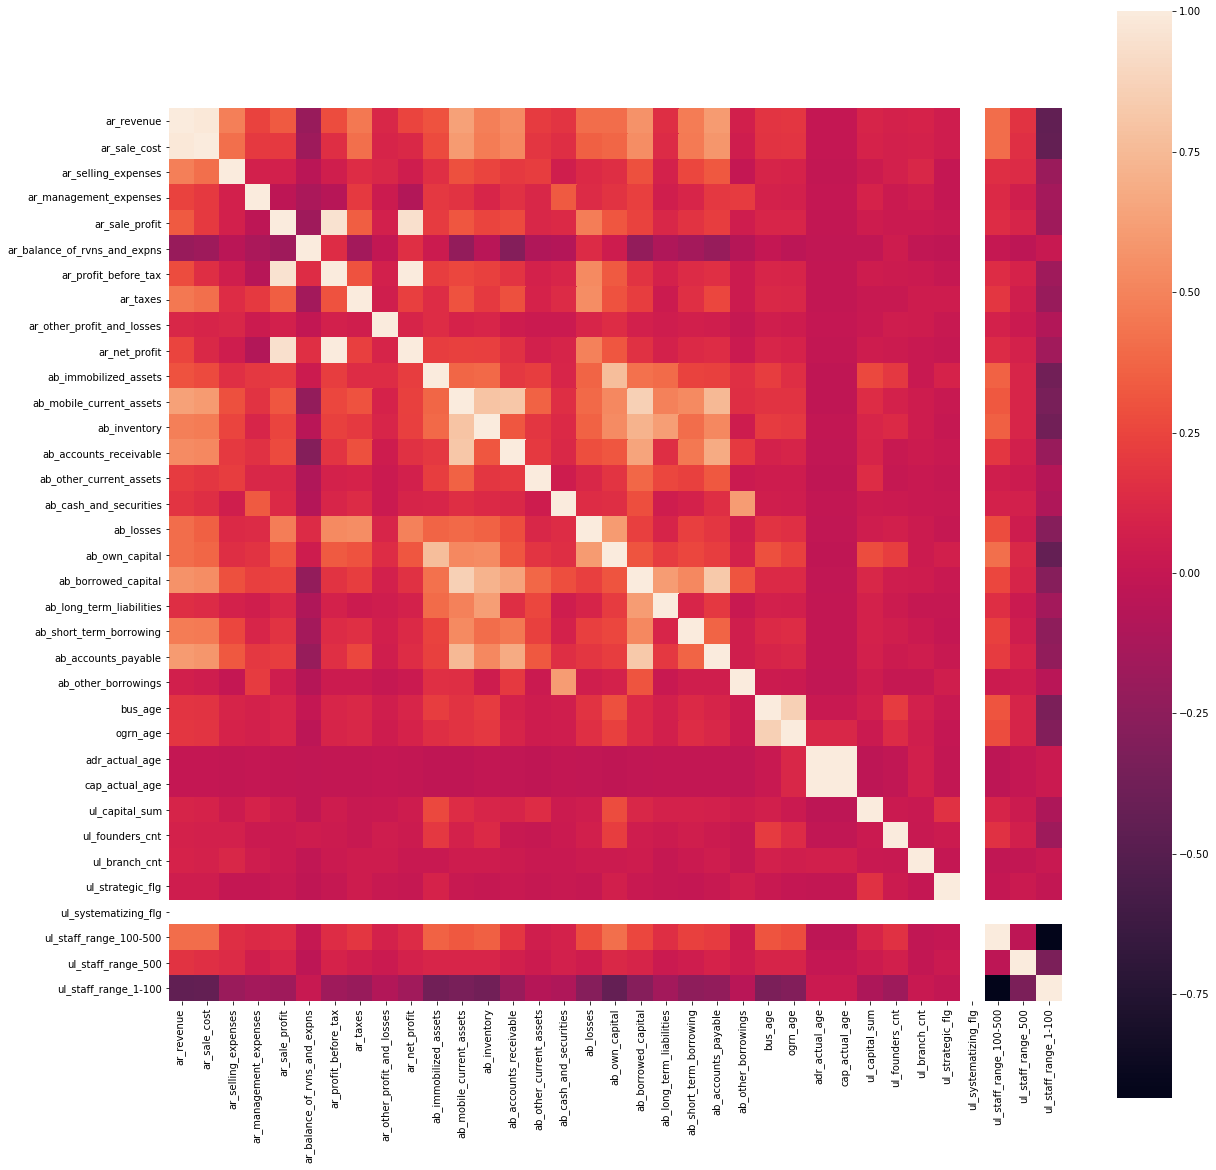

In [45]:
plt.subplots(figsize=(20,20))
sns.heatmap(short_df.corr(), square=True)
plt.show()

In [46]:
features_short = short_df.columns.tolist()

In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {'max_depth': [19], 'max_features': [15],  
              'min_samples_split': [2], 'n_estimators': [323],
              'random_state': [42]}

rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=1, n_jobs=-1)
rf_grid.fit(short_df, train_df['default_12m'])
get_best_score(rf_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


0.9373668776045687
{'max_depth': 19, 'max_features': 15, 'min_samples_split': 2, 'n_estimators': 323, 'random_state': 42}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=323,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


0.9373668776045687

In [46]:
answ_df['predict'] = (rf_grid.predict_proba(test_df_new_reg.loc[:, features_short])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [47]:
lr = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': [{0:1, 1:2}], 'intercept_scaling':[0.001, 0.01, 0.1, 1],
              'max_iter':[10, 100, 150], 'tol': [0.00001, 0.0001, 0.001]}
clf_lr = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, verbose=5)

clf_lr.fit(reg_train, train_df['default_12m'])
get_best_score(clf_lr)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:  2.1min finished


0.9277357616916191
{'C': 0.001, 'class_weight': {0: 1, 1: 2}, 'intercept_scaling': 0.001, 'max_iter': 100, 'tol': 1e-05}
LogisticRegression(C=0.001, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=True, intercept_scaling=0.001, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)


0.9277357616916191

In [48]:
answ_df['predict'] = (clf_lr.predict_proba(test_df_new_reg[features_reg])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Результата не дало, добавим фичи по финансам. 

In [46]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


In [46]:
reg_train_newf = reg_train
reg_train_newf['rent'] = reg_train_newf['ar_net_profit'] / reg_train_newf['ab_mobile_current_assets']

In [47]:
reg_train_newf.rent = reg_train_newf.rent.fillna(0.0, axis=0)

In [48]:
reg_train_newf = reg_train_newf.replace([np.inf], np.nan)
reg_train_newf.rent = reg_train_newf.rent.fillna(1.0, axis=0)

In [49]:
reg_train_newf = reg_train_newf.replace([-np.inf], np.nan)
reg_train_newf.rent = reg_train_newf.rent.fillna(-1.0, axis=0)

In [50]:
reg_train_newf['fast_liq'] = (reg_train_newf['ab_accounts_receivable'] + reg_train_newf['ab_cash_and_securities']) / (reg_train_newf['ab_short_term_borrowing'] + reg_train_newf['ab_accounts_payable'] + reg_train_newf['ab_other_borrowings'])

In [51]:
reg_train_newf.fast_liq = reg_train_newf.fast_liq.fillna(0.0, axis=0)

In [52]:
reg_train_newf = reg_train_newf.replace([np.inf], np.nan)
reg_train_newf.fast_liq = reg_train_newf.fast_liq.fillna(1.0, axis=0)

In [53]:
reg_train_newf = reg_train_newf.replace([-np.inf], np.nan)
reg_train_newf.fast_liq = reg_train_newf.fast_liq.fillna(-1.0, axis=0)

In [54]:
reg_train_newf['rent_kap'] = reg_train_newf['ar_net_profit'] / reg_train_newf['ab_own_capital']

In [55]:
reg_train_newf.rent_kap = reg_train_newf.rent_kap.fillna(0.0, axis=0)

In [56]:
reg_train_newf = reg_train_newf.replace([np.inf], np.nan)
reg_train_newf.rent_kap = reg_train_newf.rent_kap.fillna(1.0, axis=0)

In [57]:
reg_train_newf = reg_train_newf.replace([-np.inf], np.nan)
reg_train_newf.rent_kap = reg_train_newf.rent_kap.fillna(-1.0, axis=0)

In [58]:
reg_train_newf.shape

(32395, 40)

In [59]:
reg_train_newf.head()

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range_100-500,ul_staff_range_500,ul_staff_range_1-100,rent,fast_liq,rent_kap
0,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,50000.0,2,0,0,0,0,0,1,0.165470,0.157951,1.806938
1,32335000.0,29703500.0,28408000.0,0.0,0.0,1231500.0,-126000.0,850000.0,41000.0,0.0,704000.0,0.0,11094500.0,4714500.0,3028500.0,0.0,264000.0,673000.0,3528000.0,7231000.0,0.0,361000.0,3678000.0,0.0,256,135,12,12,12,10000.0,5,0,0,0,0,0,1,0.063455,0.815177,0.199546
2,32335000.0,29703500.0,28408000.0,0.0,0.0,1231500.0,-126000.0,850000.0,41000.0,0.0,704000.0,0.0,11094500.0,4714500.0,3028500.0,0.0,264000.0,673000.0,3528000.0,7231000.0,0.0,361000.0,3678000.0,0.0,33,33,28,28,28,10000.0,2,0,0,0,0,0,1,0.063455,0.815177,0.199546
3,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,300000.0,1,0,0,0,0,0,1,0.452061,0.051479,0.864804
4,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,10000.0,2,0,0,0,0,0,1,0.079441,0.653636,0.057159


In [60]:
reg_train_newf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ar_revenue                    32395 non-null  float64
 1   ar_total_expenses             32395 non-null  float64
 2   ar_sale_cost                  32395 non-null  float64
 3   ar_selling_expenses           32395 non-null  float64
 4   ar_management_expenses        32395 non-null  float64
 5   ar_sale_profit                32395 non-null  float64
 6   ar_balance_of_rvns_and_expns  32395 non-null  float64
 7   ar_profit_before_tax          32395 non-null  float64
 8   ar_taxes                      32395 non-null  float64
 9   ar_other_profit_and_losses    32395 non-null  float64
 10  ar_net_profit                 32395 non-null  float64
 11  ab_immobilized_assets         32395 non-null  float64
 12  ab_mobile_current_assets      32395 non-null  float64
 13  a

In [61]:
test_df_newf = test_df_new_reg
test_df_newf['rent'] = test_df_newf['ar_net_profit'] / test_df_newf['ab_mobile_current_assets']
test_df_newf = test_df_newf.replace([np.inf], np.nan)
test_df_newf.rent = test_df_newf.rent.fillna(1.0, axis=0)
test_df_newf = test_df_newf.replace([-np.inf], np.nan)
test_df_newf.rent = test_df_newf.rent.fillna(-1.0, axis=0)
test_df_newf.rent = test_df_newf.rent.fillna(0.0, axis=0)

In [62]:
test_df_newf['fast_liq'] = (test_df_newf['ab_accounts_receivable'] + test_df_newf['ab_cash_and_securities']) / (test_df_newf['ab_short_term_borrowing'] + test_df_newf['ab_accounts_payable'] + test_df_newf['ab_other_borrowings'])
test_df_newf.fast_liq = test_df_newf.fast_liq.fillna(0.0, axis=0)
test_df_newf = test_df_newf.replace([np.inf], np.nan)
test_df_newf.fast_liq = test_df_newf.fast_liq.fillna(1.0, axis=0)
test_df_newf = test_df_newf.replace([-np.inf], np.nan)
test_df_newf.fast_liq = test_df_newf.fast_liq.fillna(-1.0, axis=0)

In [63]:
test_df_newf['rent_kap'] = test_df_newf['ar_net_profit'] / test_df_newf['ab_own_capital']
test_df_newf.rent_kap = test_df_newf.rent_kap.fillna(0.0, axis=0)
test_df_newf = test_df_newf.replace([np.inf], np.nan)
test_df_newf.rent_kap = test_df_newf.rent_kap.fillna(1.0, axis=0)
test_df_newf = test_df_newf.replace([-np.inf], np.nan)
test_df_newf.rent_kap = test_df_newf.rent_kap.fillna(-1.0, axis=0)

In [64]:
test_df_newf.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,...,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range_100-500,ul_staff_range_500,ul_staff_range_1-100,rent,fast_liq,rent_kap
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,47000.0,0.0,6009000.0,2451000.0,3558000.0,0.0,677000.0,47000.0,1178000.0,...,0.0,3000000.0,3130000.0,0.0,156,135,3,3,3,100000.0,1,0,0,0,0,0,1,0.007822,0.690865,0.039898
1,1196,18997000.0,16456000.0,15878500.0,0.0,0.0,1184000.0,-58000.0,545000.0,73500.0,0.0,400000.0,0.0,7811500.0,4239500.0,1958500.0,0.0,216500.0,400000.0,1706500.0,...,0.0,292500.0,2182000.0,0.0,216,138,5,5,5,100000.0,1,0,0,0,0,0,1,0.051207,0.878965,0.234398
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,1467000.0,0.0,8175000.0,8037000.0,138000.0,0.0,237000.0,1467000.0,6835000.0,...,0.0,0.0,3906000.0,0.0,244,138,20,20,20,250000.0,2,0,0,0,0,0,1,0.179450,0.096006,0.214631
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,137000.0,0.0,5790000.0,4314000.0,1476000.0,0.0,35000.0,137000.0,5691000.0,...,0.0,500000.0,40000.0,0.0,272,139,9,9,9,10000.0,2,0,0,0,0,0,1,0.023661,2.798148,0.024073
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,1739000.0,0.0,65485000.0,46006000.0,19479000.0,0.0,956000.0,1739000.0,12408000.0,...,0.0,16215000.0,30802000.0,0.0,254,139,3,3,3,1700598.0,84,0,0,0,1,0,0,0.026556,0.434630,0.140152


Кореляция новых фичей околонулевая

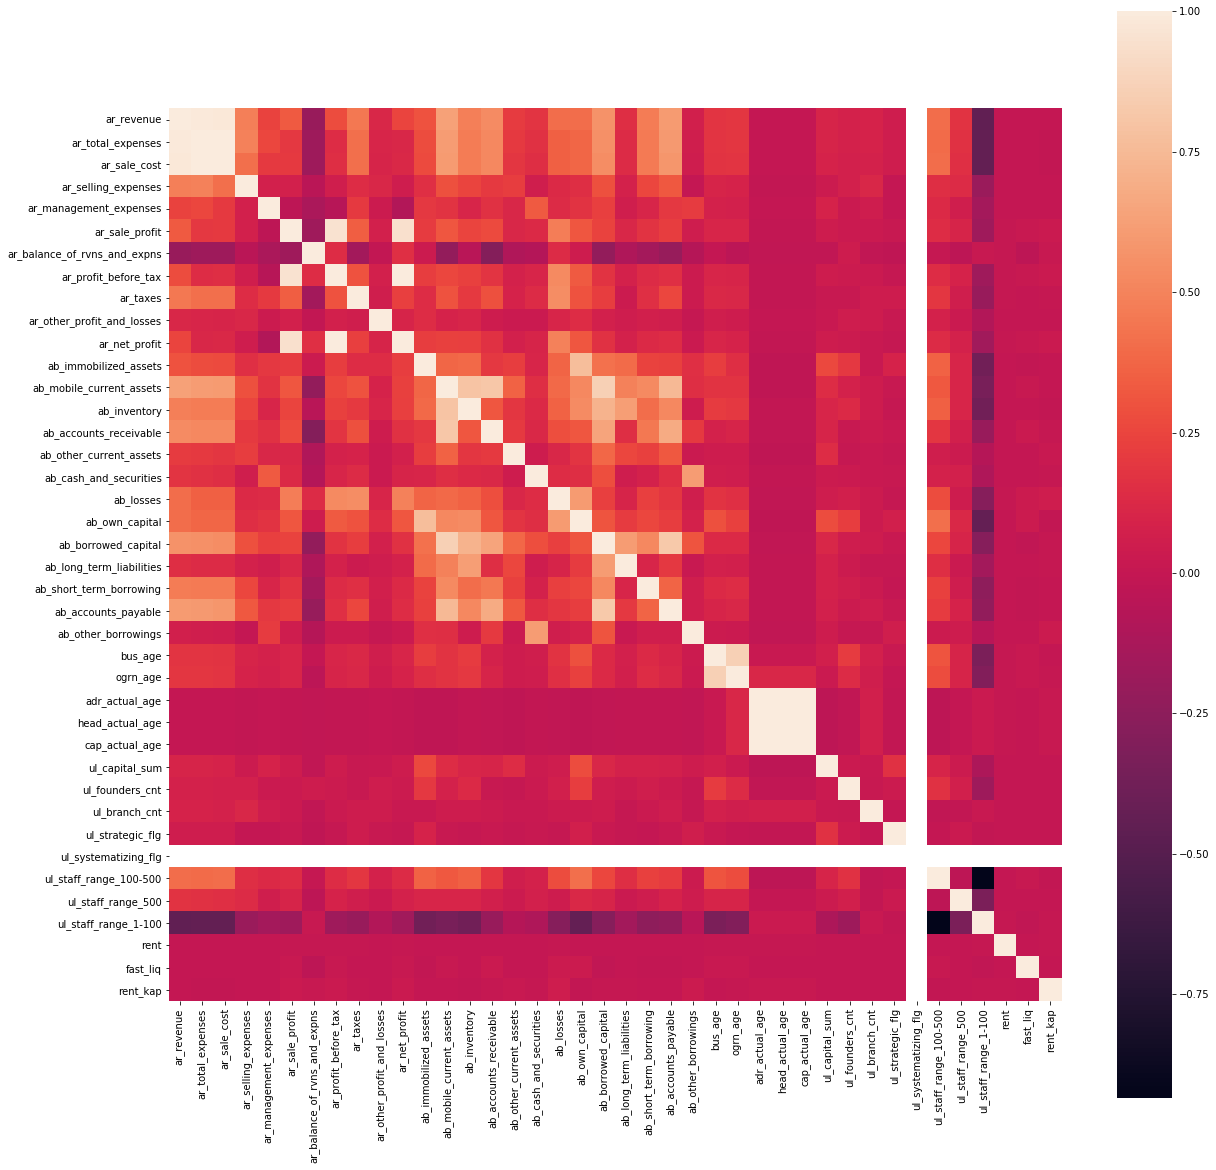

In [65]:
plt.subplots(figsize=(20,20))
sns.heatmap(reg_train_newf.corr(), square=True)
plt.show()

In [70]:
features_newf = reg_train_newf.columns.tolist()

In [66]:
lr = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': [{0:1, 1:1}], 'intercept_scaling':[0.001, 0.01, 0.1, 1],
              'max_iter':[10, 100, 150], 'tol': [0.00001, 0.0001, 0.001]}
clf_lr = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, verbose=5)

clf_lr.fit(reg_train_newf, train_df['default_12m'])
get_best_score(clf_lr)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  2.1min


0.9312856922364562
{'C': 1000, 'class_weight': {0: 1, 1: 1}, 'intercept_scaling': 0.001, 'max_iter': 100, 'tol': 1e-05}
LogisticRegression(C=1000, class_weight={0: 1, 1: 1}, intercept_scaling=0.001,
                   tol=1e-05)


[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:  2.3min finished


0.9312856922364562

In [65]:
answ_df['predict'] = (clf_lr.predict_proba(test_df_newf[features_newf])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [67]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {'max_depth': [19], 'max_features': [15],  
              'min_samples_split': [2], 'n_estimators': [323],
              'random_state': [42], 'class_weight': [{0:1, 1:1}]}

rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=1, n_jobs=-1)
rf_grid.fit(reg_train_newf, train_df['default_12m'])
get_best_score(rf_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.2s finished


0.937397746565828
{'class_weight': {0: 1, 1: 1}, 'max_depth': 19, 'max_features': 15, 'min_samples_split': 2, 'n_estimators': 323, 'random_state': 42}
RandomForestClassifier(class_weight={0: 1, 1: 1}, max_depth=19, max_features=15,
                       n_estimators=323, random_state=42)


0.937397746565828

In [71]:
answ_df['predict'] = (rf_grid.predict_proba(test_df_newf[features_newf])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [72]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

param_grid = {'min_samples_split': [2,4,7,10,12, 20, 28, 30, 33],
              'max_depth': [4, 5, 7, 10, 12, 20, 30],
              'max_features':[5, 8, 15, 20, 30],
              'ccp_alpha': [0.01, 0.1],
              'criterion': ['gini', 'entropy'],
              'class_weight': [{0:1, 1:1}],
              'random_state': [42]
             }
dtree_grid = GridSearchCV(dtree, param_grid, refit=True, verbose=1, n_jobs=-1)
dtree_grid.fit(reg_train_newf, train_df['default_12m'])
get_best_score(dtree_grid)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 1890 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 3090 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4690 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:  1.6min


0.9354530020064825
{'ccp_alpha': 0.01, 'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 4, 'max_features': 5, 'min_samples_split': 2, 'random_state': 42}
DecisionTreeClassifier(ccp_alpha=0.01, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=4, max_features=5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')


[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:  1.9min finished


0.9354530020064825

In [69]:
answ_df['predict'] = (dtree_grid.predict_proba(test_df_newf[features_newf])[:,1]>cutoff).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

NameError: name 'dtree_grid' is not defined

In [74]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier()
param_grid = {'alpha': [0.1, 0.01, 0.001, 0.0001],
              'class_weight': [{1:1}], 'random_state': [42]} 
#               'probability': ['True']}
svc_grid = GridSearchCV(model, param_grid, refit=True, verbose=5, n_jobs=-1)
svc_grid.fit(reg_train_newf, train_df['default_12m'])
get_best_score(svc_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s finished


0.9262849205124247
{'alpha': 0.1, 'class_weight': {1: 1}, 'random_state': 42}
SGDClassifier(alpha=0.1, average=False, class_weight={1: 1},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


0.9262849205124247

In [75]:
answ_df['predict'] = (svc_grid.predict(test_df_newf.loc[:, features_newf])).astype(int)
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Итог 66,5%, 9-10 ранг на борде. 
В дальнейшем попробую использовать SMOTE, а также разделить выборку на датасеты с полными данными и с пропусками. 